In [17]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import pysm3
import pysm3.units as u
from astropy import units as u
import pysm3.units as u
import numpy as np
import matplotlib.pyplot as plt
from fgbuster import CMB, Dust, Synchrotron, MixingMatrix
from fgbuster.observation_helpers import standardize_instrument, get_observation,  get_instrument
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline


In [19]:
nside = 64
instrument = get_instrument('LiteBIRD')

freq_mapsQ = get_observation(instrument, 'd0s0',nside=nside)[:,1,:]
freq_mapsU = get_observation(instrument, 'd0s0',nside=nside)[:,2,:]
freq_maps = get_observation(instrument, 'd0s0',nside=nside)

freq_mapsP = np.sqrt(np.power(freq_mapsQ,2)+np.power(freq_mapsU,2))


In [20]:
components= [CMB(),Dust(50.),Synchrotron(50.)]
A = MixingMatrix(*components)
A_ev = A.evaluator(instrument.frequency)


In [21]:
invN=np.eye(15)
invNd = np.einsum('ij,jsp->isp', invN, freq_maps)
invNd_P = np.einsum('ij,jp->ip', invN, freq_mapsP)



In [22]:
def spectral_likelihoodP(x):
    A_maxL = A_ev(x) 
    logL = 0
    AtNd= np.einsum('ji,jp->ip', A_maxL, invNd_P)
    AtNA = np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))
    logL = logL + np.einsum('ip,ij,jp->', AtNd, AtNA, AtNd)
    print(x, logL)
    if logL != logL:
        return 0.0
    return logL



[ 1.2 20.  -3. ] 12742628632.887732
[ 1.20707071 20.         -3.        ] 12742860486.324207
[ 1.21414141 20.         -3.        ] 12743087417.554579
[ 1.22121212 20.         -3.        ] 12743309420.39564
[ 1.22828283 20.         -3.        ] 12743526489.125372
[ 1.23535354 20.         -3.        ] 12743738618.4753
[ 1.24242424 20.         -3.        ] 12743945803.623737
[ 1.24949495 20.         -3.        ] 12744148040.18906
[ 1.25656566 20.         -3.        ] 12744345324.221891
[ 1.26363636 20.         -3.        ] 12744537652.199728
[ 1.27070707 20.         -3.        ] 12744725021.018599
[ 1.27777778 20.         -3.        ] 12744907427.98779
[ 1.28484848 20.         -3.        ] 12745084870.822369
[ 1.29191919 20.         -3.        ] 12745257347.636984
[ 1.2989899 20.        -3.       ] 12745424856.9395
[ 1.30606061 20.         -3.        ] 12745587397.624321
[ 1.31313131 20.         -3.        ] 12745744968.966393
[ 1.32020202 20.         -3.        ] 12745897570.614698
[ 1.3

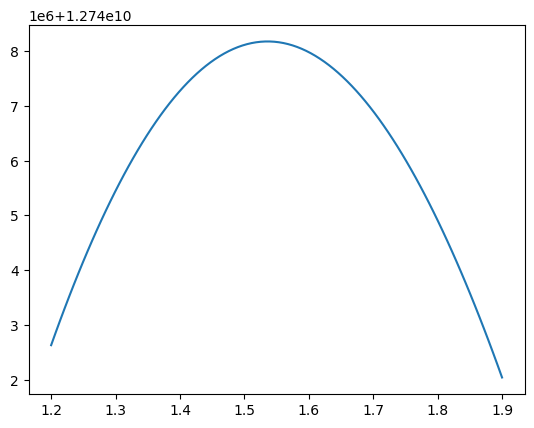

In [23]:
Betad = np.linspace(1.2,1.9,100)
result= []
for i in Betad:
    x0=np.array([i,20,-3])
    result.append(spectral_likelihoodP(x0))

plt.plot(Betad,result)



In [24]:
x0 = np.array([1.54,20,-3])
max= minimize(spectral_likelihoodP,x0)
max.x


[ 1.54 20.   -3.  ] 12748176585.85559
[ 1.54000001 20.         -3.        ] 12748176585.849901
[ 1.54       20.00000001 -3.        ] 12748176585.855415
[ 1.54       20.         -2.99999999] 12748176585.855244
[ 2.54764802 20.03107731 -2.93852097] 12705215306.544579
[ 2.54764803 20.03107731 -2.93852097] 12705215305.388224
[ 2.54764802 20.03107733 -2.93852097] 12705215306.512634
[ 2.54764802 20.03107731 -2.93852096] 12705215306.572525
[ 6.57824009 20.15538655 -2.69260486] 12238687921.476444
[ 6.57824011 20.15538655 -2.69260486] 12238687919.761667
[ 6.57824009 20.15538657 -2.69260486] 12238687921.429192
[ 6.57824009 20.15538655 -2.69260485] 12238687921.792927
[22.7006084  20.65262352 -1.70894042] 11447015464.028555
[22.70060841 20.65262352 -1.70894042] 11447015463.879795
[22.7006084  20.65262354 -1.70894042] 11447015464.024612
[22.7006084  20.65262352 -1.7089404 ] 11447015460.530067
[87.1900816  22.64157141  2.22571735] 12736708934.25064
[87.19008162 22.64157141  2.22571735] 12736708934.2

array([7517.79497765,  251.78563258,  391.88308296])

In [25]:

def spectral_likelihood(x):
    A_maxL = A_ev(x) 
    logL = 0
    AtNd= np.einsum('ji,jsp->isp', A_maxL, invNd)
    AtNA = np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))
    logL = logL + np.einsum('isp,ij,jsp->', AtNd, AtNA, AtNd)
    print(x, logL)
    if logL != logL:
        return 0.0
    return logL

[ 1.2 20.  -3. ] 27509042105264.453
[ 1.27777778 20.         -3.        ] 27514032154910.223
[ 1.35555556 20.         -3.        ] 27517725010516.79
[ 1.43333333 20.         -3.        ] 27520120256164.105
[ 1.51111111 20.         -3.        ] 27521228068115.867
[ 1.58888889 20.         -3.        ] 27521067340845.78
[ 1.66666667 20.         -3.        ] 27519664051291.953
[ 1.74444444 20.         -3.        ] 27517049840520.05
[ 1.82222222 20.         -3.        ] 27513260791539.188
[ 1.9 20.  -3. ] 27508336382445.45


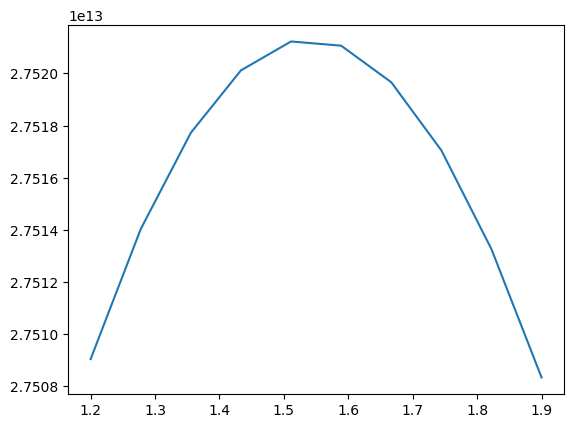

In [26]:
Betad = np.linspace(1.2,1.9,10)
result= []
for i in Betad:
    result.append(spectral_likelihood(np.array([i,20,-3])))

plt.plot(Betad,result)
 
    

In [27]:
instr = np.load('instrument_LB_IMOv1.npy', allow_pickle=True).item()
instr_ = {}
instr_['frequency'] = np.array([instr[f]['freq'] for f in instr.keys()])
instr_['depth_p'] = np.array([instr[f]['P_sens'] for f in instr.keys()])
instr_['fwhm'] = np.array([instr[f]['beam'] for f in instr.keys()])
instr_['depth_i'] = instr_['depth_p']/np.sqrt(2)
instr_standardize = standardize_instrument(instr_)

#print(instr_standardize)
print(instr)




{'LB_LFT_40': {'freq': 40.0, 'freq_band': 12.0, 'beam': 70.5, 'P_sens': 37.42}, 'LB_LFT_50': {'freq': 50.0, 'freq_band': 15.0, 'beam': 58.5, 'P_sens': 33.46}, 'LB_LFT_60': {'freq': 60.0, 'freq_band': 14.0, 'beam': 51.1, 'P_sens': 21.31}, 'LB_LFT_68a': {'freq': 68.0, 'freq_band': 16.0, 'beam': 41.6, 'P_sens': 19.91}, 'LB_LFT_68b': {'freq': 68.0, 'freq_band': 16.0, 'beam': 47.1, 'P_sens': 31.76}, 'LB_LFT_78a': {'freq': 78.0, 'freq_band': 18.0, 'beam': 36.9, 'P_sens': 15.56}, 'LB_LFT_78b': {'freq': 78.0, 'freq_band': 18.0, 'beam': 43.8, 'P_sens': 19.14}, 'LB_LFT_89a': {'freq': 89.0, 'freq_band': 20.0, 'beam': 33.0, 'P_sens': 12.28}, 'LB_LFT_89b': {'freq': 89.0, 'freq_band': 20.0, 'beam': 41.5, 'P_sens': 28.77}, 'LB_LFT_100': {'freq': 100.0, 'freq_band': 23.0, 'beam': 30.2, 'P_sens': 10.34}, 'LB_LFT_119': {'freq': 119.0, 'freq_band': 36.0, 'beam': 26.3, 'P_sens': 7.69}, 'LB_LFT_140': {'freq': 140.0, 'freq_band': 42.0, 'beam': 23.7, 'P_sens': 7.24}, 'LB_MFT_100': {'freq': 100.0, 'freq_band'